In [1]:
import pandas as pd
from sklearn import preprocessing
from collections import defaultdict
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

data_path = #Put path to file here

df = pd.read_csv(
    data_path,
    sep=',', 
    header='infer',
    index_col = "ID"
)
# remove DESTIONATION column
df.pop("DESTINATION")

# fetch categorical columns before doing any other preprocessing
cat_mask = (df.dtypes == object)
cat_cols= df.columns[cat_mask].tolist()

# remove all rows containing NA values (47 of them)
df = df.dropna()

# drop all rows where the important values are all 0
df.drop(df[(df["TEMP"] == 0) & (df["HEART_RATE"] == 0) &  (df["GLUCOSE"] == 0) & ( df["SAT_O2"] == 0) & (df["BLOOD_PRES_SYS"] == 0) & (df["BLOOD_PRES_DIAS"] == 0)].index)

# only remove the very big outliers, the smaller ones might be relevant
df = df.drop(df[(df["HEART_RATE"] > 400)].index)
df = df.drop(df[(df["BLOOD_PRES_SYS"] > 600)].index)
df = df.drop(df[(df["BLOOD_PRES_DIAS"] > 400)].index)
df = df.drop(df[(df["AGE"] > 180)].index)

# create 2 separate dataframes, categorical and numerical
df_cat = df[cat_cols]
df_num = df.drop(cat_cols, axis = 1)
# does a bit encoding for SEX and EXITUS
d = defaultdict(preprocessing.LabelEncoder)
df_cat_le = df_cat.apply(lambda col: d[col.name].fit_transform(col))

df = pd.merge(left = df_cat_le, right = df_num, on = "ID")


In [2]:
X = df.drop(['EXITUS'], axis=1)
y = df['EXITUS'].values

# Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

print('Size train: ' + str(len(X_train)))
print('Size test: ' + str(len(X_test)))

Size train: 1601
Size test: 401


In [3]:
clf = RandomForestClassifier(n_estimators= 16, max_depth = 8, random_state=9)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=16, random_state=9)

AUC: 0.877
Acc: 0.86
Precision: 0.647
Recall: 0.333
F1: 0.44
Conf. Matrix: 


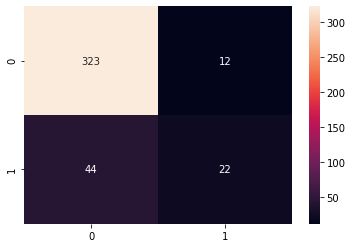

In [4]:
y_pred = clf.predict(X_test)
print('AUC: ' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]).round(3)))

def plot_metrics(y_test, y_pred):
  print('Acc: ' + str(accuracy_score(y_test, y_pred).round(3)))
  print('Precision: ' + str(precision_score(y_test, y_pred).round(3)))
  print('Recall: ' + str(recall_score(y_test, y_pred).round(3)))
  print('F1: ' + str(f1_score(y_test, y_pred).round(3)))
  print('Conf. Matrix: ')
  #print(confusion_matrix(y_test, y_pred))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

  return None

plot_metrics(y_test,y_pred)

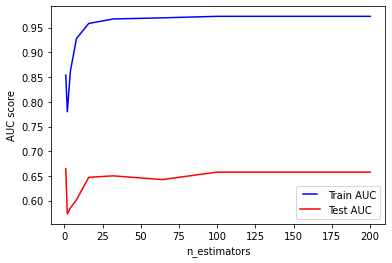

In [5]:

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1,random_state=9)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc) 
    y_pred = rf.predict(X_test)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

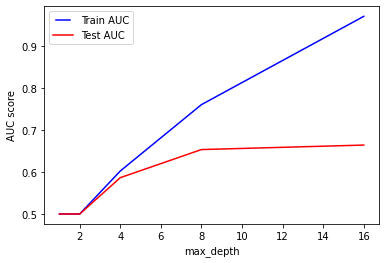

In [6]:
max_depth = [1, 2, 4, 8, 16]
train_results = []
test_results = []
for depth in max_depth:
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state= 9)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc) 
    y_pred = rf.predict(X_test)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depth, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depth, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_depth")
plt.show()